In [25]:
# импорт необходимых библиотек
import pandas as pd
import re
import time
import numpy as np
import pickle
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics # набор метрик для оценки качества модели
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import GridSearchCV  # модуль поиска по сетке параметров
from sklearn.linear_model import LogisticRegression # Логистическая регрессия

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from pymystem3 import Mystem

In [26]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rus_k\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Подготовка данных

In [27]:
# словарь видов договоров
with open('data/kind_names.json', 'r', encoding='utf8') as f:
    kind_names = json.load(f)
kind_names

{'1': 'Договор аренды',
 '2': 'Договор купли-продажи',
 '3': 'Договор оказания услуг',
 '4': 'Договор подряда',
 '5': 'Договор поставки'}

In [28]:
# загрузка данных в датафрейм
df = pd.read_csv('data/contracts_df.csv')
df.head()

,contract_id,kind_id,kind_name,greate_date,contract_name,contract,text,lemm_text_list,lemm_text
0,1,5,Договор поставки,2022-12-26,5908cb5da047d6c9e6dfea6337fb3189.doc,\r\t\tДОГОВОР \r\rг. Москва«__» ________ 2012...,договор г москва г ...,"['г', 'москва', 'г', 'общество', 'с', 'огранич...",г москва г общество с ограниченный ответственн...
1,2,5,Договор поставки,2022-12-26,14711e4fc8e56f0c75856c8837ec04cb.doc,"\r\r\rДоговор №______________\r\r\r Дата, мест...",договор дата место закл...,"['дата', 'место', 'заключение', 'населенный', ...",дата место заключение населенный пункт именова...
2,3,5,Договор поставки,2022-12-26,7eb67b5aecf3f3190aab0a5f8ea32172.docx,\r\r\t\t\r\rДОГОВОР ЗАКУПКИ № __________/\r\rг...,договор закупки г ...,"['закупка', 'г', 'г', 'общество', 'с', 'ограни...",закупка г г общество с ограниченный ответствен...
3,4,5,Договор поставки,2022-12-26,b40a9d048b199d5f4db62a6a2335f2a0.pdf,\rДОГОВОР ПОСТАВКИ № 1 \rг. Москва «11...,договор поставки г москва ...,"['поставка', 'г', 'москва', 'декабрь', 'г', 'о...",поставка г москва декабрь г общество с огранич...
4,5,5,Договор поставки,2022-12-26,84fec112d02288861e7af59f468131fb.docx,\rДоговор № {НомерДокумента}\r{ДатаДокумента...,договор номердокумента датадокумента ...,"['номердокумент', 'датадокумент', 'названиекон...",номердокумент датадокумент названиеконтры имен...


In [29]:
# ограничение количества слов в списке лемматизированных слов договора
MAX_WORD = 1000 # подбирается наилучший по метрике на кроссвалидации 

In [30]:
%%time
df['lemm_text_list'] = df['lemm_text_list'].apply(lambda x: eval(x)[:MAX_WORD])
# формируем столбец 'lemm_text' - лемматизированный тест для последующей обработки в TfidfVectorizer
df['lemm_text'] = df['lemm_text_list'].apply(lambda x: ' '.join(x))

CPU times: total: 219 ms
Wall time: 216 ms


In [31]:
# лемматизированный текст договора
X = df['lemm_text']
# целевой признак - номер класса
y = df['kind_id']

# Модель

In [32]:
# инициализация TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 3), max_features=1000)

In [33]:
# обучение TfidfVectorizer
X_grid = vectorizer.fit_transform(X)  

In [34]:
# сохранение обученного TfidfVectorizer в файл
dest = os.path.join('data', 'pkl_object')
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(vectorizer,
            open(os.path.join(dest, 'vectorizer.pkl'), 'wb'),
            protocol=4)

In [35]:
%%time
# кросс-валидация на 5 фолдах и вывод метрик
metrics_for_model = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
best_metrics = []
for scoring in metrics_for_model:
    logit = LogisticRegression(random_state=12345)
    logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C':[5],
                                                                    'solver': ['liblinear'],
                                                                    'max_iter':[100]},
                                       scoring=scoring, n_jobs=-1, cv=5)
    logit_grid_searcher.fit(X_grid, y)
    best_metrics.append(logit_grid_searcher.best_score_)
    
columns = ['Метрика', 'Показатель метрики'] 
metrics_itog = pd.DataFrame(index=[1, 2, 3, 4], data=metrics_for_model)
metrics_itog[1] = best_metrics 
metrics_itog.columns = columns
metrics_itog

CPU times: total: 141 ms
Wall time: 4.69 s


,Метрика,Показатель метрики
1,accuracy,0.975000
2,precision_macro,0.979000
3,recall_macro,0.972000
4,f1_macro,0.970667


In [36]:
# сохранение обученной модели в файл
pickle.dump(logit_grid_searcher,
            open(os.path.join(dest, 'logit_grid_searcher.pkl'), 'wb'),
            protocol=4)

# Тестирование модели

In [37]:
# формирование обучающей и тестовой выборки в соотношении 50% и 50% от всех доступных данных
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.5, stratify=y, random_state=12345)
# если задать разбиение 70% на 30% то метрики будут 100 процентные !!!

In [38]:
# обучение на трейне и применение на тесте TfidfVectorizer 
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000) # инициализация TfidfVectorizer
X_train = vectorizer.fit_transform(X_train) # обучение TfidfVectorizer на трейне
X_test = vectorizer.transform(X_test) # применение обученного TfidfVectorizer на тесте

In [39]:
# инициализация логистической регрессии (гиперпараметры по умолчанию)
lr = LogisticRegression(random_state=12345, C = 5, max_iter = 100, solver = 'liblinear')
# обучение логистической регрессии на трейне
lr.fit(X_train, y_train)
# получение предсказаний на тесте
y_pred = lr.predict(X_test) 

In [40]:
# вывод метрик и confusion_matrix
accuracy_score(y_test, y_pred)

0.95

In [41]:
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.9539335664335665, 0.949318181818182, 0.9507918660287082, None)

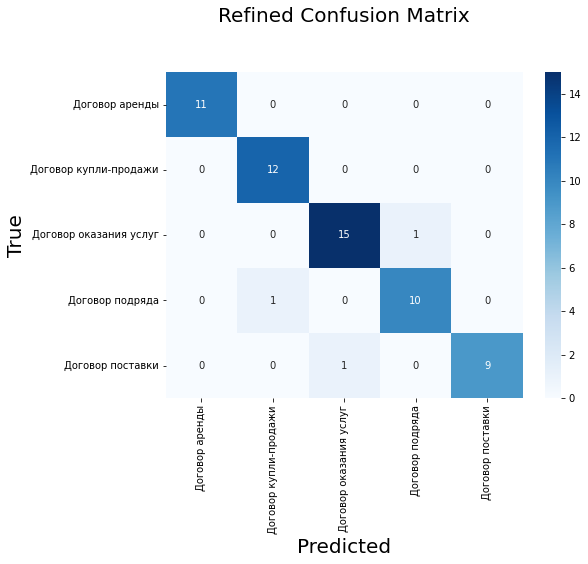

In [42]:
cm = confusion_matrix(y_test, y_pred)
class_names = kind_names.values()
fig = plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize=10)
ax.xaxis.tick_bottom()
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize=10)
plt.yticks(rotation=0)
plt.title('Refined Confusion Matrix', fontsize=20, pad=50)
plt.show()

# Предсказание вида для нового договора

In [43]:
# случайный (новый) договор
contract = df['contract'].sample(1).values[0]
contract[:200]

'\rДОГОВОР № _____\r\rг. Санкт-Петербург\x07« ___ » _____________ 201___ г.\x07\x07\r__________________________, именуемое в дальнейшем «Поставщик», в лице ___________________, действующего на основании __________,'

In [49]:
m = Mystem()
# функция трансформации текста договора для предсказания
def ContractTransform(text):
    
    text = text.lower()
    text = re.sub('[^а-яА-ЯёЁ]', ' ', text)
    lemm_text_list = [i for i in m.lemmatize(text) if len(i.strip()) > 0] 
    lemm_text_list = [word for word in lemm_text_list if 'договор' not in word and 'сторон' not in word]
    lemm_text_list = lemm_text_list[:MAX_WORD]
    
    return pd.Series(' '.join(lemm_text_list))   

In [50]:
# трансформация текста случайного (нового) договора
X_test = ContractTransform(contract)
X_test

0    г санкт петербург г именовать в дальнейший пос...
dtype: object

In [46]:
# применение векторайзера
X_test = vectorizer.transform(X_test)

In [47]:
# получение предсказаного номера класса
class_number = logit_grid_searcher.predict(X_test)[0]
class_number

2

In [48]:
# получение предсказаного названия вида договора (в текстовом виде)
kind_names[str(class_number)]

'Договор купли-продажи'